In [ ]:
!pip install geomloss

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm
from torchvision.models import resnet50, ResNet50_Weights, vgg16,VGG16_Weights
import pickle
import os
import cv2
import json
from tqdm import tqdm
from geomloss import SamplesLoss

In [ ]:
from google.colab import drive
drive.mount('/content/data', force_remount=True)

Mounted at /content/data


### Find the list of frames

In [ ]:
data_path = '/content/data/MyDrive/'
files = os.listdir(data_path+'droplets/')
files = [f.split(".")[0] for f in files]
files = list(set(files))
print(len(files))

1170


In [ ]:
def load_images(file):
    return np.array(cv2.imreadmulti(file, flags=cv2.IMREAD_GRAYSCALE)[1], dtype=object)
def load_json(file):
    with open(file) as f:
        return json.load(f)

In [ ]:
class CellsDataset(Dataset):
    def __init__(self, files, data_path,train = True , transform=None, seed = 42, test_size = 0.1):
        self.files = files
        self.data_path = data_path
        self.transform = transform
        self.seed = seed
        self.test_size = test_size
        self.images = []
        temp = [load_json(data_path+'generated/'+ f+'.json') for f in tqdm(files)]
        self.data = []
        for t, file in tqdm(zip(temp, files)):
            images = load_images(data_path+'droplets/' + file +'.tif')
            for i in range(len(t['valid_bb'])):
                if t['valid_bb'][i] == 0 or len(t['cell'][i]) > 200:
                    continue
                self.images.append(images[i])
                t['cell'][i] = t['cell'][i] + [[-1,-1]] * (200 - len(t['cell'][i]))
                self.data.append({'frame': t['file_name'], 'bb': t['bb'][i], 'cell': t['cell'][i]})
        random.seed(self.seed)
        test_id = random.sample(range(len(self.images)), int(len(self.images)*self.test_size))


        if  train:
            self.images = [self.images[i] for i in range(len(self.images)) if i not in test_id]
            self.data = [self.data[i] for i in range(len(self.data)) if i not in test_id]
        else:
            self.images = [self.images[i] for i in range(len(self.images)) if i in test_id]
            self.data = [self.data[i] for i in range(len(self.data)) if i in test_id]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        data = self.data[idx]
        image = np.array(image).astype(np.float32)
        if self.transform:
            image = self.transform(image)

        bb = data['bb']
        cell = data['cell']
        bb = torch.from_numpy(np.array(bb))
        cell = torch.from_numpy(np.array(cell))

        return {'frame': data['frame'], 'image': image, 'bb': bb, 'cell': cell}


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.Resize((448,448)),
    transforms.ToTensor(),
])

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(5, 5)
        self.fc1 = nn.Linear(253476, 1024)  # Adjusted input size
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 200 * 2)

    def forward(self, image, bb):
        x = self.pool(self.activation(self.conv2(self.activation(self.conv1(image)))))
        x = x.view(-1, 253472)
        x = torch.cat((x, bb), dim=1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 200, 2)



In [ ]:
net = CNN()

In [ ]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)

cuda:0


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=253476, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=400, bias=True)
)

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=10):
        super().__init__()
        self.alpha = alpha

    def forward(self, pred, target):
        nb_pred = torch.sum((pred[:, :, 0] >= 0) & (pred[:, :, 1] >= 0))
        nb_target = torch.sum((target[:, :, 0] >= 0) & (target[:, :, 1] >= 0))
        nb_loss = torch.abs(nb_pred - nb_target)**2

        pred = pred[(pred[:, :, 0] >= 0) & (pred[:, :, 1] >= 0)].double()
        target = target[(target[:, :, 0] >= 0) & (target[:, :, 1] >= 0)].double()
        dist_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.05)(pred, target)
        return dist_loss + nb_loss * self.alpha


In [ ]:
lr = 0.0001
criterion = CustomLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)


In [ ]:
trainset = CellsDataset(files, data_path, transform=transform)
trainloader = DataLoader(trainset, batch_size=2, shuffle=True, num_workers=0)

testset = CellsDataset(files, data_path, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=2, shuffle=True, num_workers=0)



100%|██████████| 1170/1170 [07:32<00:00,  2.59it/s]
1170it [07:39,  2.55it/s]
100%|██████████| 1170/1170 [00:01<00:00, 879.52it/s]
1170it [00:11, 102.39it/s]


In [ ]:
nb_epoch = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

train_losses = []
test_losses = []

for epoch in range(nb_epoch):
    running_train_loss = 0.0
    running_test_loss = 0.0

    # Training loop
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        image = data['image'].to(device)
        bb = data['bb'].to(device)
        labels = data['cell'].to(device)
        bb = data['bb'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net(image, bb)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        running_train_loss += train_loss


        if i % 100 == 99:
            avg_train_loss = running_train_loss/100

            print('[%d, %5d] average training loss on last 100 items : %.3f' %
                (epoch + 1, i + 1, avg_train_loss))

            train_losses.append(avg_train_loss)
            running_train_loss = 0.0  # reset running_train_loss

    # Testing loop
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(testloader):
            image = data['image'].to(device)
            bb = data['bb'].to(device)
            labels = data['cell'].to(device)

            outputs = net(image, bb)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            running_test_loss += test_loss

        avg_test_loss = running_test_loss / len(testloader)
        test_losses.append(avg_test_loss)

        print('[%d] average test loss: %.3f' % (epoch + 1, avg_test_loss))

    net.train()  # Set the model back to training mode



[1,   100] average training loss on last 100 items : 290663.934
[1,   200] average training loss on last 100 items : 55510.400
[1,   300] average training loss on last 100 items : 53344.622
[1,   400] average training loss on last 100 items : 50451.046
[1,   500] average training loss on last 100 items : 46260.304
[1,   600] average training loss on last 100 items : 49965.963
[1,   700] average training loss on last 100 items : 48077.146
[1,   800] average training loss on last 100 items : 44862.133
[1,   900] average training loss on last 100 items : 42431.428
[1,  1000] average training loss on last 100 items : 36207.913
[1] average test loss: 33048.822
[2,   100] average training loss on last 100 items : 30757.947
[2,   200] average training loss on last 100 items : 29192.305
[2,   300] average training loss on last 100 items : 25530.603
[2,   400] average training loss on last 100 items : 28104.676
[2,   500] average training loss on last 100 items : 25962.533
[2,   600] average tr

In [ ]:
def plot_results(testloader, net, device):
    dataiter = iter(testloader)
    data = next(dataiter)

    images = data['image'].to(device)
    bb = data['bb'].to(device)
    labels = data['cell'].to(device)

    outputs = net(images, bb)
    outputs = outputs.detach().to("cpu").numpy()
    labels = labels.detach().to("cpu").numpy()
    images = images.detach().to("cpu").numpy()

    # Remove bounding box's upper-left coordinates from points
    # outputs[:, :, 0] -= bb[0][0].to("cpu").numpy()
    # outputs[:, :, 1] -= bb[0][1].to("cpu").numpy()
    # labels[:, :, 0] -= bb[0][0].to("cpu").numpy()
    # labels[:, :, 1] -= bb[0][1].to("cpu").numpy()

    # Set non-positive coordinates to NaN
    outputs[outputs <= 0] = np.nan
    labels[labels <= 0] = np.nan

    for i in range(len(images)):
        nb_predic = np.sum(~np.isnan(outputs[i][:, 0]))
        nb_target = np.sum(~np.isnan(labels[i][:, 0]))

        # Get original bounding box coordinates
        orig_bb = bb[i].to("cpu").numpy()

        # plt.imshow(images[i][0], extent=(orig_bb[0], orig_bb[0] + orig_bb[2], orig_bb[1], orig_bb[1] + orig_bb[3]))

        plt.title('Number of predicted points = '+str(nb_predic)+'\nNumber of original points = '+str(nb_target))
        plt.scatter(outputs[i][:, 0], outputs[i][:, 1], c='r', s=10, label="Predicted")
        plt.scatter(labels[i][:, 0], labels[i][:, 1], c='b', s=10, label="Original")
        plt.legend()
        plt.show()

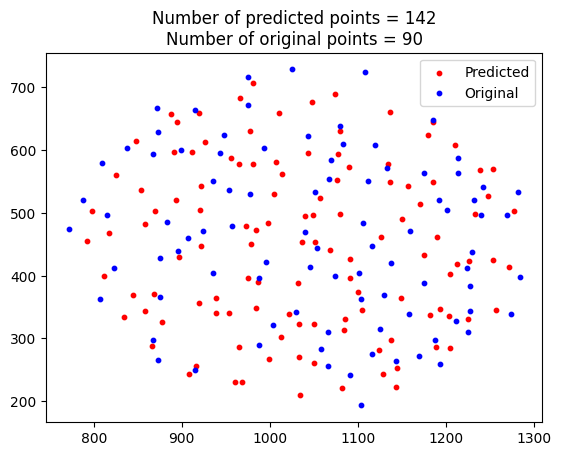

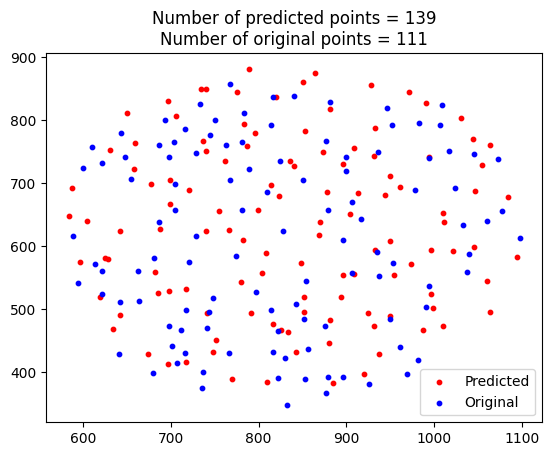

In [ ]:
plot_results(testloader, net, "cuda:0")

In [ ]:
torch.save(net.state_dict(), f'/content/data/MyDrive/weights_NN/02_12_23.pth')